### Cidades que desmataram mais de 20.000 campos de futebol em 2020

Área de um campo de futebol (oficial Fifa): 8105$m^2$

1 Hectare = 10000$m^2$

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import basedosdados as bd
import geobr

In [2]:
area = 8105
campos = 20000
area_campos = area * campos
area_campos_ha = area_campos / 10000
area_campos_ha

16210.0

In [3]:
query = """
WITH desmat as (
  SELECT id_municipio, SUM(area) as area_total
  FROM `basedosdados.br_mapbiomas_estatisticas.transicao_municipio_de_para_anual`
  WHERE ano BETWEEN 1999 AND 2019
    AND de_nivel_2 = "1.1. floresta natural"
    AND para_nivel_1 = "3. agropecuaria"
    AND area > {campos}
  GROUP BY id_municipio
  )

SELECT t1.sigla_uf, t1.nome, desmat.id_municipio, desmat.area_total
FROM desmat
INNER JOIN `basedosdados.br_bd_diretorios_brasil.municipio` AS t1
ON desmat.id_municipio = t1.id_municipio
ORDER BY desmat.area_total DESC
""".format(campos = area_campos_ha)

df = bd.read_sql(query, billing_project_id = 'projeto1-311803')

Downloading: 100%|██████████████████████████████████████████████████████████████████| 93/93 [00:00<00:00, 157.50rows/s]


In [4]:
df

,sigla_uf,nome,id_municipio,area_total
0,PA,São Félix do Xingu,1507300,1.165900e+06
1,RO,Porto Velho,1100205,7.128316e+05
2,PA,Altamira,1500602,5.558670e+05
3,PA,Paragominas,1505502,4.518411e+05
4,PA,Novo Repartimento,1505064,3.980872e+05
...,...,...,...,...
88,RR,Cantá,1400175,1.702311e+04
89,RO,São Miguel do Guaporé,1100320,1.681042e+04
90,RR,Caroebe,1400233,1.641500e+04
91,MT,Bom Jesus do Araguaia,5101852,1.630467e+04


### Ranking 20 cidades

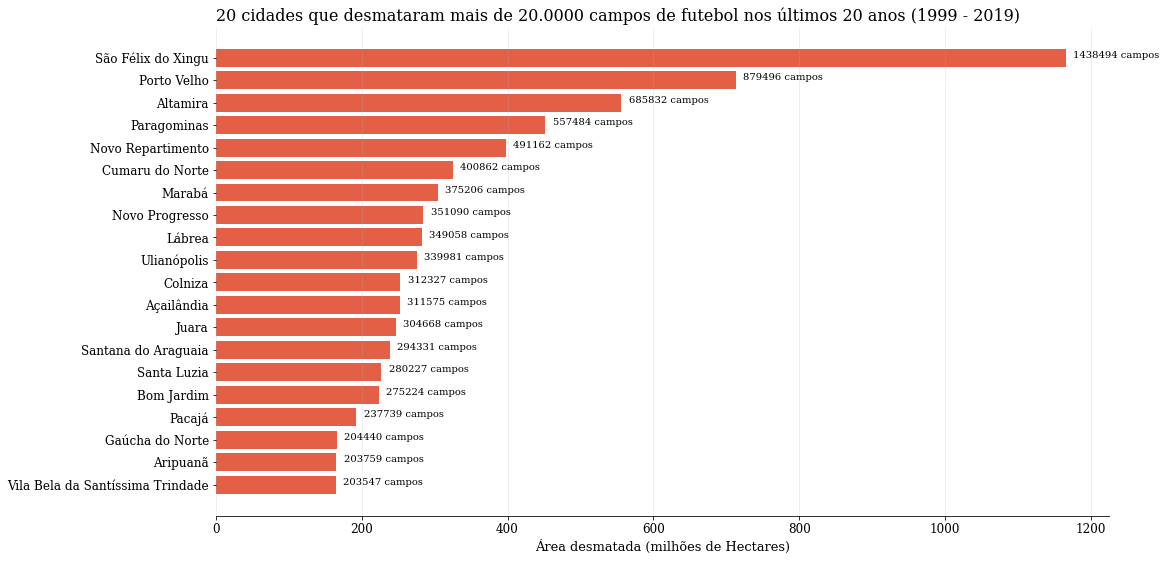

In [54]:
# Configurando fontes do plot
plt.rcParams['font.family'] = 'serif'

# Figura e Axes
fig, ax = plt.subplots(figsize = (16,9))

# Variáveis para plotar
y = df['nome'].iloc[:20]
x = df['area_total'].iloc[:20]

# plotando
barras = ax.barh(y = y, width = x, color = '#E36046')
ax.invert_yaxis()

# título
ax.set_title('20 cidades que desmataram mais de 20.0000 campos de futebol nos últimos 20 anos (1999 - 2019)',
             loc = 'left',
             fontsize = 16)
# X-Axis
xtick_labels = np.arange(0, 1400, step = 200)
ax.set_xticklabels(xtick_labels, fontdict = {'fontsize':12})
ax.set_xlabel('Área desmatada (milhões de Hectares)', fontsize = 13)

# Y-Axis
ax.set_yticklabels(y, fontsize = 12)

# spines
spines = ['top', 'left', 'right']
for spine in spines:
    ax.spines[spine].set_visible(False)
    
# grids
ax.grid(axis = 'x', alpha = .25)

# área em campos
for barra in barras:
    largura = barra.get_width()
    ax.text(x = largura + 10000, y = barra.get_y() + barra.get_height() / 2, s = f'{int(round(largura / (area/10000)))} campos')

plt.show()

In [55]:
fig.savefig('ranking_desmatadores.jpg', edgecolor = 'none', bbox_inches = 'tight')

### Mapa

**Ambiente `geoenv`**

In [164]:
# UFs utilizadas
estados = ['AC', 'AM', 'RO', 'RR', 'AP', 'PA', 'MT', 'TO']

# Função para obter geometrias
def geom(ufs):
    geom_muni = []
    geom_uf = []
    for uf in ufs:
        data_muni = geobr.read_municipality(code_muni = uf)
        data_uf = geobr.read_state(code_state = uf)
        geom_muni.append(data_muni)
        geom_uf.append(data_uf)
    geom_muni = pd.concat(geom_muni)
    geom_muni['code_muni'] = geom_muni['code_muni'].astype(int).astype(str)
    geom_uf = pd.concat(geom_uf)
    return (geom_muni, geom_uf)

In [138]:
# dataframes com geometrias
geom_cidades, geom_estados = geom(estados)

In [139]:
# juntando dataframes
df_mapa = geom_cidades.merge(df, left_on = 'code_muni', right_on = 'id_municipio', how = 'outer')

In [140]:
# preenchendo nans
df_mapa['area_total'] = df_mapa['area_total'].fillna(0)

In [141]:
df_mapa.sort_values(by = 'area_total', ascending = False)

,code_muni,name_muni,code_state,abbrev_state,geometry,sigla_uf,nome,id_municipio,area_total
285,1507300,São Félix Do Xingu,15.0,PA,"POLYGON ((-51.44782 -5.15021, -50.92723 -5.151...",PA,São Félix do Xingu,1507300,1.165900e+06
100,1100205,Porto Velho,11.0,RO,"MULTIPOLYGON (((-63.93601 -8.59286, -63.92457 ...",RO,Porto Velho,1100205,7.128316e+05
174,1500602,Altamira,15.0,PA,"POLYGON ((-52.36944 -3.11836, -52.36546 -3.111...",PA,Altamira,1500602,5.558670e+05
254,1505502,Paragominas,15.0,PA,"POLYGON ((-46.83025 -2.41854, -46.82042 -2.418...",PA,Paragominas,1505502,4.518411e+05
246,1505064,Novo Repartimento,15.0,PA,"POLYGON ((-50.67625 -4.20807, -50.67329 -4.208...",PA,Novo Repartimento,1505064,3.980872e+05
...,...,...,...,...,...,...,...,...,...
202,1502400,Castanhal,15.0,PA,"POLYGON ((-48.00923 -1.20608, -47.96917 -1.202...",NaN,NaN,NaN,0.000000e+00
201,1502301,Capitão Poço,15.0,PA,"POLYGON ((-47.11299 -1.55372, -47.11128 -1.552...",NaN,NaN,NaN,0.000000e+00
200,1502202,Capanema,15.0,PA,"POLYGON ((-47.21201 -1.00085, -47.19899 -1.002...",NaN,NaN,NaN,0.000000e+00
199,1502152,Canaã Dos Carajás,15.0,PA,"POLYGON ((-49.97488 -6.24906, -49.82325 -6.248...",NaN,NaN,NaN,0.000000e+00


In [181]:
# coluna qualitativa
df_mapa['quant_campos'] = df_mapa['area_total'] / (area / 10000)

bins = [0, 20000, 40000, 60000, 80000, 100000, float('Inf')]

df_mapa['quali'] = pd.cut(df_mapa['quant_campos'],
                          bins = bins,
                          labels=['até 20.000',
                                  'entre 20.000 e 40.000',
                                  'entre 40.000 e 60.000',
                                  'entre 60.2000 e 80.000',
                                  'entre 80.000 e 100.000',
                                  'mais de 100.000'],
                         right = True,
                         include_lowest = True)

In [251]:
df_mapa.sort_values(by = 'area_total', ascending = False).head()

,code_muni,name_muni,code_state,abbrev_state,geometry,sigla_uf,nome,id_municipio,area_total,quant_campos,quali
285,1507300,São Félix Do Xingu,15.0,PA,"POLYGON ((-51.44782 -5.15021, -50.92723 -5.151...",PA,São Félix do Xingu,1507300,1.165900e+06,1.438494e+06,mais de 100.000
100,1100205,Porto Velho,11.0,RO,"MULTIPOLYGON (((-63.93601 -8.59286, -63.92457 ...",RO,Porto Velho,1100205,7.128316e+05,8.794961e+05,mais de 100.000
174,1500602,Altamira,15.0,PA,"POLYGON ((-52.36944 -3.11836, -52.36546 -3.111...",PA,Altamira,1500602,5.558670e+05,6.858322e+05,mais de 100.000
254,1505502,Paragominas,15.0,PA,"POLYGON ((-46.83025 -2.41854, -46.82042 -2.418...",PA,Paragominas,1505502,4.518411e+05,5.574844e+05,mais de 100.000
246,1505064,Novo Repartimento,15.0,PA,"POLYGON ((-50.67625 -4.20807, -50.67329 -4.208...",PA,Novo Repartimento,1505064,3.980872e+05,4.911625e+05,mais de 100.000


In [252]:
df_mapa.sort_values(by = 'area_total').head()

,code_muni,name_muni,code_state,abbrev_state,geometry,sigla_uf,nome,id_municipio,area_total,quant_campos,quali
0,1200013,Acrelândia,12.0,AC,"MULTIPOLYGON (((-67.14117 -9.68337, -67.13885 ...",NaN,NaN,NaN,0.0,0.0,até 20.000
408,5107008,Poxoréo,51.0,MT,"POLYGON ((-54.12541 -15.62666, -54.11696 -15.6...",NaN,NaN,NaN,0.0,0.0,até 20.000
407,5106851,Porto Estrela,51.0,MT,"POLYGON ((-57.24897 -15.29187, -57.24593 -15.2...",NaN,NaN,NaN,0.0,0.0,até 20.000
404,5106778,Porto Alegre Do Norte,51.0,MT,"POLYGON ((-52.18569 -10.82787, -52.18295 -10.8...",NaN,NaN,NaN,0.0,0.0,até 20.000
402,5106703,Ponte Branca,51.0,MT,"POLYGON ((-52.91447 -16.81265, -52.91679 -16.8...",NaN,NaN,NaN,0.0,0.0,até 20.000


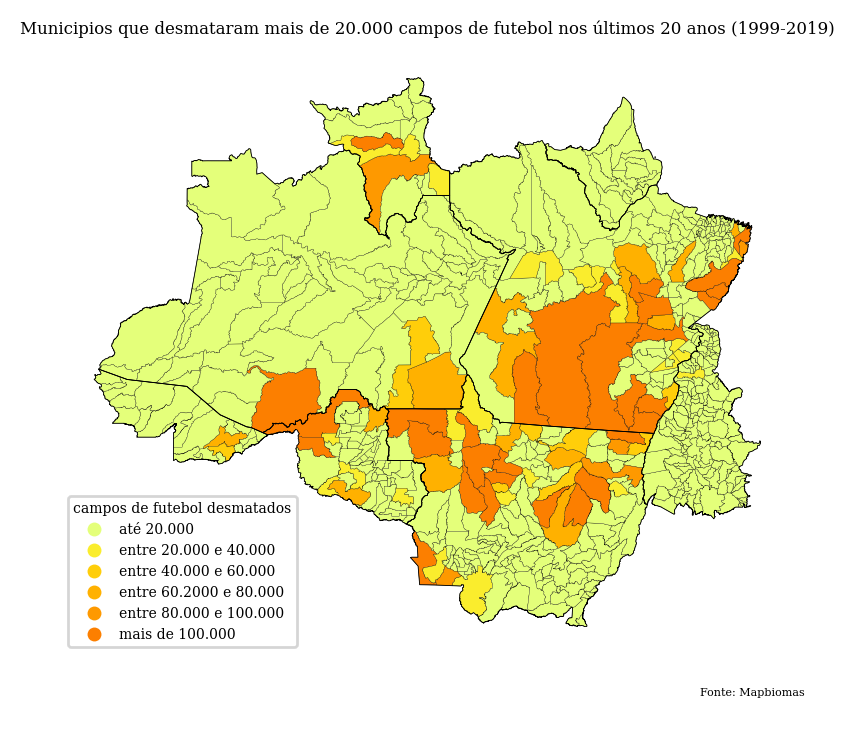

In [248]:
# configurando fontes do mapa
plt.rcParams['font.family'] = 'serif'

# Figura e Axes
fig, ax = plt.subplots(figsize=(5, 4), dpi=200)

# plotando municipios
df_mapa.plot(
    column="quali",
    cmap="Wistia",
    lw = .1,
    ec = 'k',
    legend = True,
    legend_kwds = {'title':'campos de futebol desmatados',
                   'title_fontsize':5,
                   'loc':'lower left',
                   'fontsize':5,
                   'markerscale': .5},
    axes=ax,
)

# plotando limites dos estados
geom_estados.boundary.plot(edgecolor = 'k', linewidth = .3, ax = ax)

# anotações
ax.annotate(text = 'Fonte: Mapbiomas', xy = (.7, .05), xycoords = 'figure fraction', fontsize = 4)

# axis
ax.axis('off')

# titulo
ax.set_title('Municipios que desmataram mais de 20.000 campos de futebol nos últimos 20 anos (1999-2019)',
             fontsize = 6)

plt.show()

In [249]:
fig.savefig('mapa_desmat.jpg', bboxs_inches = 'tight')